<a href="https://colab.research.google.com/github/vladiant/MachineLearningUtils/blob/main/Pix2Pix/Pix2PixGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix GAN for Image-to-Image Translation
https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

## Setup the GPU

In [ ]:
import tensorflow as tf

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset
http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [ ]:
# Change to the folder where the images datasets are loaded/present and where the 
WORKPLACE_FOLDER = "/tmp"

In [ ]:
# https://stackabuse.com/download-files-with-python/

import requests
from os import path

print('Beginning file download with requests')

url = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
local_tar_file = 'maps.tar.gz'
r = requests.get(url)

with open(path.join(WORKPLACE_FOLDER,local_tar_file), 'wb') as f:
    f.write(r.content)

# Retrieve HTTP meta-data
print("Request status code", r.status_code)
print("Request content type", r.headers['content-type'])
print("Request encode", r.encoding)

Beginning file download with requests
Request status code 200
Request content type application/x-gzip
Request encode None


In [ ]:
# !tar -xf  /tmp/maps.tar.gz --directory /tmp

In [ ]:
import tarfile

my_tar = tarfile.open(path.join(WORKPLACE_FOLDER,local_tar_file))
my_tar.extractall(WORKPLACE_FOLDER)
my_tar.close()

## Load datafiles and process the data

In [ ]:
from os import listdir, path

from numpy import asarray, vstack, savez_compressed

from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
# Load all images in a directory into memory
def load_images(file_path, size=(256, 512)):
  src_list, tar_list = list(), list()
  # Enumerate filenames in directory, assume all are images
  for filename in listdir(file_path):
    # Load and resize the image
    pixels = load_img(path.join(file_path,filename), target_size=size)
    # Convert to numpy array
    pixels = img_to_array(pixels)
    # Split into satellite and map
    sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)

  return [asarray(src_list), asarray(tar_list)]

In [ ]:
# Dataset path
file_path = path.join(WORKPLACE_FOLDER,'maps/train')

In [ ]:
# Load dataset
[src_images, tar_images] = load_images(file_path)
src_images.shape, tar_images.shape

((1096, 256, 256, 3), (1096, 256, 256, 3))

In [ ]:
# Save as compressed numpy array
filename = path.join(WORKPLACE_FOLDER,'maps_256.npz')

In [ ]:
savez_compressed(filename,src_images, tar_images)
filename

'/tmp/maps_256.npz'

## Load prepared dataset

In [ ]:
from numpy import load

from matplotlib import pyplot

In [ ]:
# Load the prepared dataset
data = load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']
src_images.shape, tar_images.shape

((1096, 256, 256, 3), (1096, 256, 256, 3))

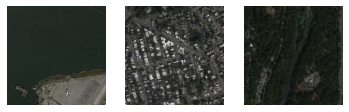

In [ ]:
# Plot source images
n_samples = 3
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(src_images[i].astype('uint8'))

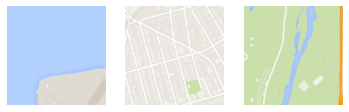

In [ ]:
# Plot target images
n_samples = 3
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(tar_images[i].astype('uint8'))

In [ ]:
from numpy import load, zeros, ones
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, Input

from matplotlib import pyplot

## Define the discriminator model

In [ ]:
def define_discriminator(image_shape):
	# Weight initialization
	init = RandomNormal(stddev=0.02)
	# Source image input
	in_src_image = Input(shape=image_shape)
	# Target image input
	in_target_image = Input(shape=image_shape)
	# Concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# Second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# Patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# Define model
	model = Model([in_src_image, in_target_image], patch_out)
	# Compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
# Define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# Weight initialization
	init = RandomNormal(stddev=0.02)
	# Add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# Conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# Leaky ReLu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
# Define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# Weight initialization
	init = RandomNormal(stddev=0.02)
	# Add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# Add batch normalization
	g = BatchNormalization()(g, training=True)
	# Conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# Merge with skip connection
	g = Concatenate()([g, skip_in])
	# Relu activation
	g = Activation('relu')(g)
	return g

##  Define the standalone generator model

In [ ]:
def define_generator(image_shape=(256,256,3)):
	# Weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# Encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# Bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# Define model
	model = Model(in_image, out_image)
	return model

## Define the combined generator and disciminator model

In [ ]:
def define_gan(g_model, d_model, image_shape):
	# Make weights in the discriminator not trainable
	d_model.trainable = False
	# Define the source image
	in_src = Input(shape=image_shape)
	# Connect the source image to the generator input
	gen_out = g_model(in_src)
	# Connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# Compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

## Load and prepare train images

In [ ]:
# To translate Google Maps to Satellite Images:
# change the order of the datasets returned
def load_real_samples(filename):
	# Load compressed arrays
	data = load(filename)
	# Unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# Scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# Select a batch of random samples, return images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# Unpack dataset
	trainA, trainB = dataset
	# Choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# Generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# Generate a batch of images, return images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# Generate fake instance
	X = g_model.predict(samples)
	# Create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# Generate samples, save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# Select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# Generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# Plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# Plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# Plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# Save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# Save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

## Train pix2pix model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
# Load image data
# filename = path.join(WORKPLACE_FOLDER,'maps_256.npz')
dataset = load_real_samples(filename)
dataset[0].shape, dataset[1].shape

((1096, 256, 256, 3), (1096, 256, 256, 3))

In [ ]:
# Define input shape based on loaded dataset
image_shape = dataset[0].shape[1:]

In [ ]:
# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

In [ ]:
# Define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
# Train model
train(d_model, g_model, gan_model, dataset)

Предаденият резултат е скъсен до последните 5000 реда.
>104602, d1[0.000] d2[0.000] g[2.920]
>104603, d1[0.000] d2[0.000] g[3.234]
>104604, d1[0.000] d2[0.000] g[2.705]
>104605, d1[0.000] d2[0.000] g[3.054]
>104606, d1[0.000] d2[0.000] g[2.828]
>104607, d1[0.000] d2[0.000] g[1.500]
>104608, d1[0.000] d2[0.000] g[2.739]
>104609, d1[0.000] d2[0.000] g[0.565]
>104610, d1[0.000] d2[0.000] g[2.598]
>104611, d1[0.000] d2[0.000] g[0.842]
>104612, d1[0.000] d2[0.000] g[2.854]
>104613, d1[0.000] d2[0.000] g[2.333]
>104614, d1[0.000] d2[0.000] g[3.745]
>104615, d1[0.000] d2[0.000] g[1.834]
>104616, d1[0.000] d2[0.000] g[2.436]
>104617, d1[0.000] d2[0.000] g[3.957]
>104618, d1[0.000] d2[0.000] g[0.693]
>104619, d1[0.000] d2[0.000] g[3.031]
>104620, d1[0.000] d2[0.000] g[1.939]
>104621, d1[0.000] d2[0.000] g[2.819]
>104622, d1[0.000] d2[0.000] g[1.924]
>104623, d1[0.000] d2[0.000] g[1.145]
>104624, d1[0.000] d2[0.000] g[3.166]
>104625, d1[0.000] d2[0.000] g[2.735]
>104626, d1[0.000] d2[0.000] g[2.

## Load a model to translate images

In [ ]:
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

In [ ]:
# load and prepare training images
# To translate Google Maps to Satellite Images:
# change the order of the datasets returned
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


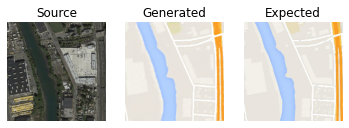

In [ ]:
# load dataset
# filename = path.join(WORKPLACE_FOLDER,'maps_256.npz')
[X1, X2] = load_real_samples(filename)
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_109600.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)